## Assessment of damage associated with Russia's invasion of Ukraine in 2022

Download all libraries needed for this project

In [1]:
import pandas as pd
import numpy as np
import folium as F
%matplotlib inline 
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from math import log10, floor

# print('Matplotlib version: ', mpl.__version__)
# print(plt.style.available)
mpl.style.use(['ggplot'])

Read the CSV files into a Pandas DataFrame

In [2]:
russian_personnel = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_personnel.csv')
russian_equipment = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_equipment.csv')

## Data Cleaning
### Let's start by getting a basic understanding of the DataFrame and cleaning the data

In [3]:
russian_personnel.head(10)

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0
1,2022-02-26,3,4300,about,0
2,2022-02-27,4,4500,about,0
3,2022-02-28,5,5300,about,0
4,2022-03-01,6,5710,about,200
5,2022-03-02,7,5840,about,200
6,2022-03-03,8,9000,about,200
7,2022-03-04,9,9166,about,200
8,2022-03-05,10,10000,about,216
9,2022-03-06,11,11000,about,232


In [4]:
#remove confusing columns and set index for sorting by date.
russian_personnel.drop(['personnel', 'personnel*'], axis=1, inplace=True)
russian_personnel.set_index('date', inplace=True)
russian_personnel.info()
russian_personnel.head()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 2022-02-25 to 2022-05-05
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   day     70 non-null     int64
 1   POW     70 non-null     int64
dtypes: int64(2)
memory usage: 1.6+ KB


,day,POW
date,,
2022-02-25,2,0
2022-02-26,3,0
2022-02-27,4,0
2022-02-28,5,0
2022-03-01,6,200


In [5]:
russian_equipment.head(10)

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles
0,2022-02-25,2,10,7,80,516,49,4,100.0,60.0,0,2,0,NaN,NaN,NaN,NaN
1,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN
2,2022-02-27,4,27,26,150,706,50,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN
3,2022-02-28,5,29,29,150,816,74,21,291.0,60.0,3,2,5,NaN,NaN,NaN,NaN
4,2022-03-01,6,29,29,198,846,77,24,305.0,60.0,3,2,7,NaN,NaN,NaN,NaN
5,2022-03-02,7,30,31,211,862,85,40,355.0,60.0,3,2,9,NaN,NaN,NaN,NaN
6,2022-03-03,8,30,31,217,900,90,42,374.0,60.0,3,2,11,NaN,NaN,NaN,NaN
7,2022-03-04,9,33,37,251,939,105,50,404.0,60.0,3,2,18,NaN,NaN,NaN,NaN
8,2022-03-05,10,39,40,269,945,105,50,409.0,60.0,3,2,19,NaN,NaN,NaN,NaN
9,2022-03-06,11,44,48,285,985,109,50,447.0,60.0,4,2,21,NaN,NaN,NaN,NaN


In [6]:
#fill empty spaces in Dataframe with zeroes and set index for sorting by date.
russian_equipment = russian_equipment.fillna(0)
russian_equipment.set_index('date', inplace=True)
russian_equipment.info()
russian_equipment.head()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 2022-02-25 to 2022-05-05
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   day                      70 non-null     int64  
 1   aircraft                 70 non-null     int64  
 2   helicopter               70 non-null     int64  
 3   tank                     70 non-null     int64  
 4   APC                      70 non-null     int64  
 5   field artillery          70 non-null     int64  
 6   MRL                      70 non-null     int64  
 7   military auto            70 non-null     float64
 8   fuel tank                70 non-null     float64
 9   drone                    70 non-null     int64  
 10  naval ship               70 non-null     int64  
 11  anti-aircraft warfare    70 non-null     int64  
 12  special equipment        70 non-null     float64
 13  mobile SRBM system       70 non-null     float64
 14  vehicles and fue

,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles
date,,,,,,,,,,,,,,,,
2022-02-25,2,10,7,80,516,49,4,100.0,60.0,0,2,0,0.0,0.0,0.0,0.0
2022-02-26,3,27,26,146,706,49,4,130.0,60.0,2,2,0,0.0,0.0,0.0,0.0
2022-02-27,4,27,26,150,706,50,4,130.0,60.0,2,2,0,0.0,0.0,0.0,0.0
2022-02-28,5,29,29,150,816,74,21,291.0,60.0,3,2,5,0.0,0.0,0.0,0.0
2022-03-01,6,29,29,198,846,77,24,305.0,60.0,3,2,7,0.0,0.0,0.0,0.0


In [7]:
#Change all numberic data to integer.
russian_equipment = russian_equipment.astype({'special equipment':np.int64, 'mobile SRBM system':np.int64})
russian_equipment.info()


<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 2022-02-25 to 2022-05-05
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   day                      70 non-null     int64  
 1   aircraft                 70 non-null     int64  
 2   helicopter               70 non-null     int64  
 3   tank                     70 non-null     int64  
 4   APC                      70 non-null     int64  
 5   field artillery          70 non-null     int64  
 6   MRL                      70 non-null     int64  
 7   military auto            70 non-null     float64
 8   fuel tank                70 non-null     float64
 9   drone                    70 non-null     int64  
 10  naval ship               70 non-null     int64  
 11  anti-aircraft warfare    70 non-null     int64  
 12  special equipment        70 non-null     int64  
 13  mobile SRBM system       70 non-null     int64  
 14  vehicles and fue

## Problem 1
##### Visually represent the country being invaded.

In [8]:
## Coordinates as at 03/31/2021 obtained from googlemaps
ukraine_latitude = 48.383022 
ukrain_longitude = 31.1828699
ukraine_map = F.Map(location=[ukraine_latitude, ukrain_longitude], tiles="Stamen Terrain", zoom_start=6.49)

kiev = F.map.FeatureGroup()

kiev_latitude =50.4500336
kiev_longitude =30.5241361
kiev.add_child(F.features.CircleMarker([kiev_latitude, kiev_longitude], radius=5, color="red", fill_color="blue"))
ukraine_map.add_child(kiev)

F.Marker([kiev_latitude, kiev_longitude], popup="Ukraine's Capital").add_to(ukraine_map)

ukraine_map

## Problem 2
##### Show the total Prisoners of War per day recorded in the Personel table.


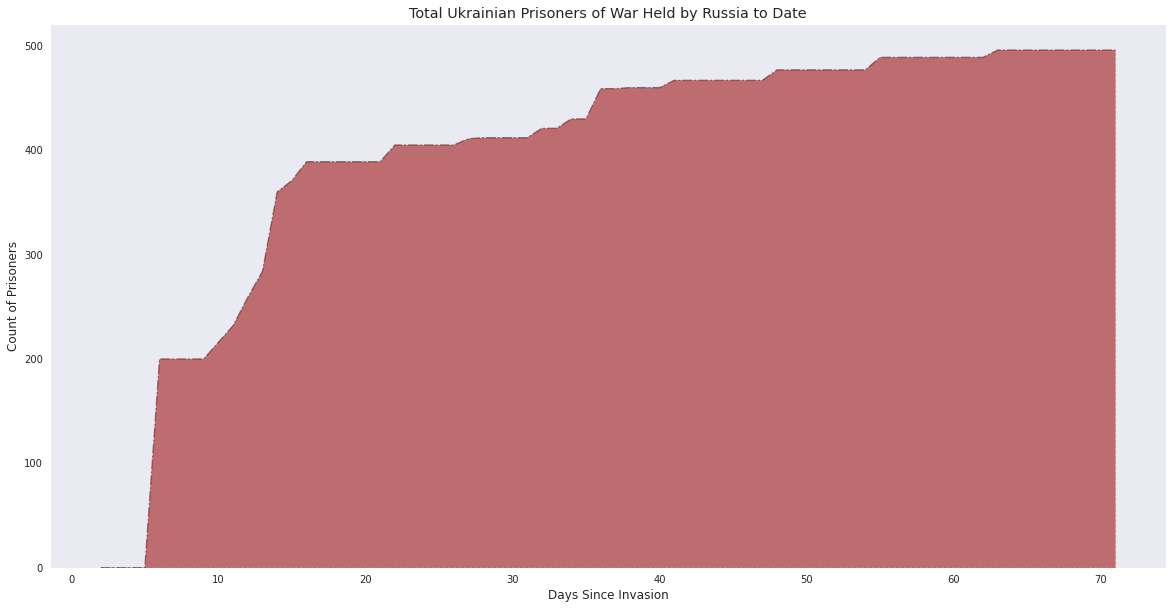

In [9]:
# Set graph style
sns.set_style('dark')

# Refine data
pow_data = russian_personnel[["day", "POW"]]
pow_data.reset_index('date', inplace=True)

# Create and label plot
pow_data.plot(kind='area', x='day', y='POW', color='brown', alpha =.65, figsize=(20,10), legend=False, linestyle="-.")
plt.title('Total Ukrainian Prisoners of War Held by Russia to Date')
plt.xlabel('Days Since Invasion')
plt.ylabel("Count of Prisoners")
plt.show()

## Problem 3
##### What is the daily change in POW and Total POW?

In [10]:
# Helper Variables
last = 0
increase = []

# Calculate daily change in POW
for i in (pow_data['POW'].values):
    count = i - last
    increase.append(count)
    last = i
    
# Assign new values to table    
pow_data['Daily Increase in Prisoners of War'] = increase

# Style table
pow_data_ = pow_data[['day', 'POW', 'Daily Increase in Prisoners of War']].set_index('day')
pow_data_.rename(columns={'POW':'Daily Total Prisoners of War'}, inplace=True)
pow_data_

,Daily Total Prisoners of War,Daily Increase in Prisoners of War
day,,
2,0,0
3,0,0
4,0,0
5,0,0
6,200,200
...,...,...
67,496,0
68,496,0
69,496,0


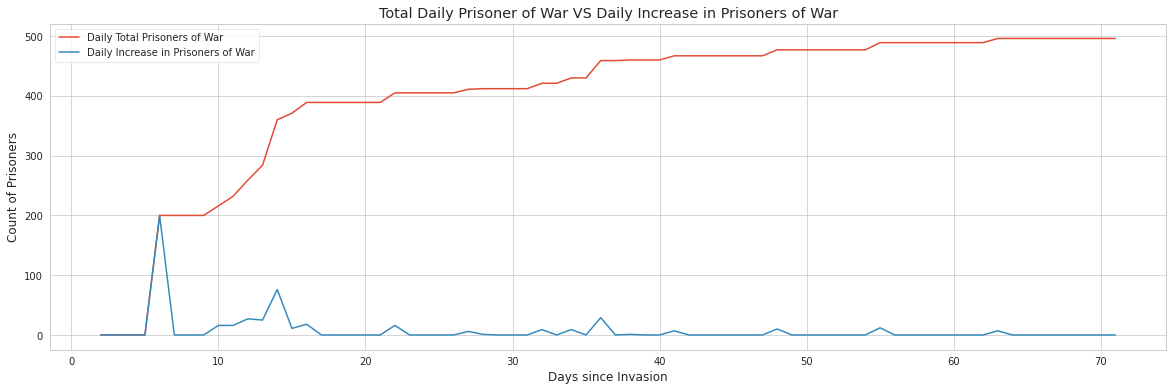

In [11]:
# Set graph style
sns.set_style('whitegrid')

# Create graph
pow_data_.plot(figsize=(20,6))
plt.xlabel('Days since Invasion')
plt.ylabel('Count of Prisoners')
plt.title("Total Daily Prisoner of War VS Daily Increase in Prisoners of War")
plt.show()

## Problem 4
##### Visualize the daily change in POW.

count    62.000000
mean      4.774194
std      11.673733
min       0.000000
25%       0.000000
50%       0.000000
75%       4.750000
max      76.000000
Name: Daily Increase in Prisoners of War, dtype: float64


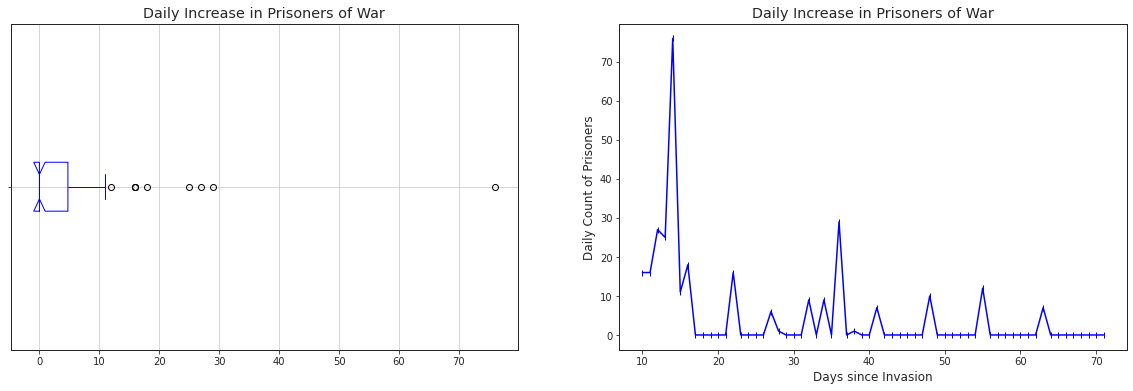

In [12]:
sns.set_style('ticks')

# Create Plot Object
fig = plt.figure()
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Assessing data after day 10 when POW is within a more narrow/normalized range. See above graph
plot_data1=pow_data_['Daily Increase in Prisoners of War'][8:]
print(plot_data1.describe())

# Subplot 1: Box plot
plot_data1.plot(kind='box', color='blue', figsize=(20, 6), vert=False, ax=ax0, notch=True, label="", grid=True) 
ax0.set_title('Daily Increase in Prisoners of War')


# Subplot 2: Line plot
plot_data1.plot(color='blue', figsize=(20,6), ax=ax1, marker="|")
ax1.set_xlabel('Days since Invasion')
ax1.set_ylabel('Daily Count of Prisoners')
ax1.set_title("Daily Increase in Prisoners of War")

# Print graph
plt.show()

## Problem 5
##### What Is the total daily loss for all equipment?

In [13]:
# Structure data from dataset
daily_total_equip_loss = russian_equipment.reset_index('date')
daily_total_equip_loss.drop(columns={'date'}, inplace=True)
daily_total_equip_loss.set_index('day', inplace=True)

# Create new dataframe for graph object
daily_total_equip_loss['Daily Total Equipment Loss'] = pd.DataFrame(daily_total_equip_loss.sum(axis=1))

# Create and show graph
plot_data2 = daily_total_equip_loss[['Daily Total Equipment Loss']]
fig=px.scatter(plot_data2, x=plot_data2.index, y='Daily Total Equipment Loss', marginal_x='box', 
               color='Daily Total Equipment Loss')
fig.update_layout(plot_bgcolor='rgba(0,5,5,0)')
fig.update_layout(title={'text':'Total Russian Equipment Lost Daily','y':0.93,'x':0.5,'xanchor':'center','yanchor':'top'})
fig.show()

## Problem 6
##### Create a word map visual to show the equipment types with the highest percentage loss in total equipment loss.

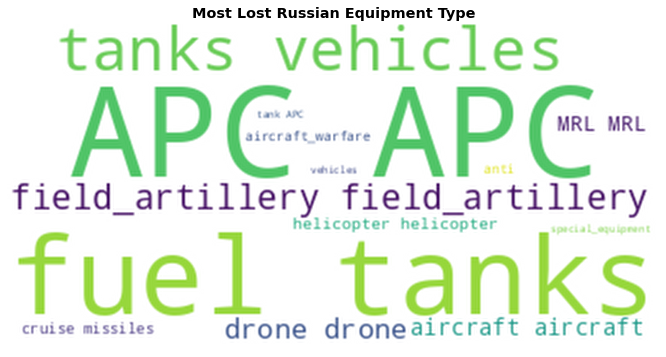

In [14]:
sns.set_style('white')
# Get the most recent loss data
total = int(daily_total_equip_loss.iloc[-1: , -1:].values)

total_loss = daily_total_equip_loss.iloc[-1: , :-1]
total_loss.reset_index(inplace=True)
total_loss = pd.DataFrame(total_loss.drop('day', axis=1).transpose()).reset_index()
total_loss.rename(columns={'index':'Equipment', 0:'Count'}, inplace=True)
total_loss.set_index('Equipment', inplace=True)
total_loss.rename(index={'field artillery':'field_artillery','military auto':'military_auto', 'fuel tank':'fuel_tank',
                         'naval ship':'naval_ship', 'anti-aircraft warfare':'anti-aircraft_warfare', 
                         'special equipment':'special_equipment', 'mobile SRBM system':'mobile_SRBM_system'}, inplace=True)

# duplicate equipment name based on how much they contribute to total loss
word_string=""
max_words = 260
for equipment in total_loss.index:
     times_repeat = int(total_loss.loc[equipment, 'Count']/total * max_words)
     word_string = word_string + ((equipment + " ") * times_repeat)

# create word cloud
word_cloud = WordCloud(background_color = 'white').generate(word_string)

# Display cloud
plt.figure(figsize=(20,6))
plt.imshow(word_cloud, interpolation='bessel')
plt.title('Most Lost Russian Equipment Type', fontweight='bold', color='black')
plt.axis('off')
plt.show()

## Problem 7
##### How much equipment did Russia lose in the first 5 days of the invasion?

In [15]:
daily_total_equip_loss.head(4).transpose()

day,2,3,4,5
aircraft,10.0,27.0,27.0,29.0
helicopter,7.0,26.0,26.0,29.0
tank,80.0,146.0,150.0,150.0
APC,516.0,706.0,706.0,816.0
field artillery,49.0,49.0,50.0,74.0
MRL,4.0,4.0,4.0,21.0
military auto,100.0,130.0,130.0,291.0
fuel tank,60.0,60.0,60.0,60.0
drone,0.0,2.0,2.0,3.0
naval ship,2.0,2.0,2.0,2.0


## Problem 8
##### What is the most recent count of equipment loss?

In [16]:
daily_total_equip_loss.tail(1)

,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles,Daily Total Equipment Loss
day,,,,,,,,,,,,,,,,
71,196,155,1092,2651,499,169,0.0,0.0,312,10,83,38,0,1907.0,89.0,7201.0


## Problem 9
##### Is there any correlation between the POW and equipment loss?

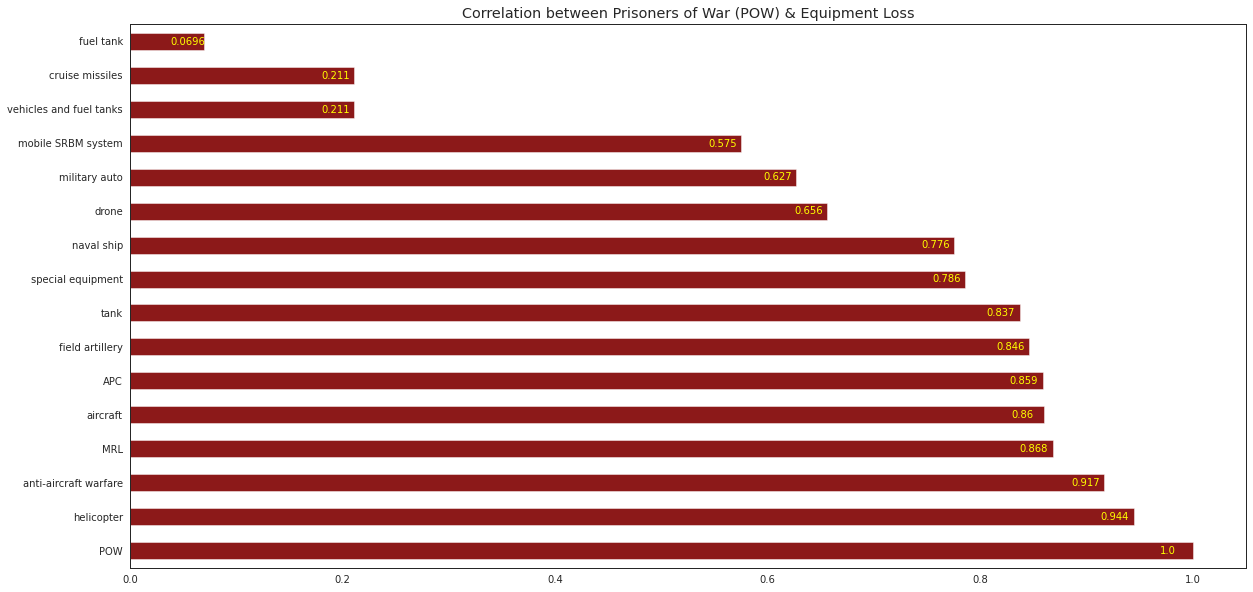

In [17]:
sns.set_style('white')
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

merge = pd.merge(russian_equipment, russian_personnel).drop(['day'], axis=1)
merged = merge.corr()['POW'].sort_values(ascending=False)

merged.plot.barh(title='Correlation between Prisoners of War (POW) & Equipment Loss',
                 figsize=(20,10),alpha=.9,color='maroon')
for index, value in enumerate(merged):
    value = round_sig(value)
    label = format(value)
    plt.annotate(label, xy=(value-.031, index-.1), color='yellow')

## Problem 10
##### What inferences can you make from the relationship between POW and Equipment loss?

In [18]:
merged.describe()

count    16.000000
mean      0.690132
std       0.285919
min       0.069588
25%       0.613698
50%       0.811477
75%       0.862115
max       1.000000
Name: POW, dtype: float64

In [19]:
m =merged.describe()
k = merged.keys()
v = merged.values

print(f"There is a very strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. \
As the POW increases, so does the overall equipment loss. The strength in correlation, ranges from {round_sig(v[1])} \
({k[1]}) to {round_sig(v[-1])} ({k[-1]}). The median correlation is {round_sig(m[-3])} and it falls between {k[6]} and \
{k[7]}. The standard deviation is {round_sig(m[2])} which indicated that the there is not much variability in the data; \
all points are close to the mean. It is then valid to conclude that as the invasion continues, and POW increases so will \
overall equipment loss especially the loss of {k[1]} by at least {round_sig(m[1])}. Proving further that this invasion is \
causing more short-term damage for both parties than it is causing good. Both Russia and Ukraine are experiencing \
exponensial losses as the days progress.")

There is a very strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. As the POW increases, so does the overall equipment loss. The strength in correlation, ranges from 0.944 (helicopter) to 0.0696 (fuel tank). The median correlation is 0.811 and it falls between field artillery and tank. The standard deviation is 0.286 which indicated that the there is not much variability in the data; all points are close to the mean. It is then valid to conclude that as the invasion continues, and POW increases so will overall equipment loss especially the loss of helicopter by at least 0.69. Proving further that this invasion is causing more short-term damage for both parties than it is causing good. Both Russia and Ukraine are experiencing exponensial losses as the days progress.


<!-- It should be noted that the strongest correlation exists not between the equipmet type with the highest loss({}) but with the type that had the ({}) highest loss. -->


## Upvote 